### Sensibilidad al Error en las Observaciones

Figure saved as: 
 PDF: /home/jorge.gacitua/experimentos/L96_multiple_experiments/figures/Figure_AnalysisRMSE_Nens20_Freq4_Den0.5_Type3_ObsErr25_NTemp3_NOGEC.pdf 
 PNG: /home/jorge.gacitua/experimentos/L96_multiple_experiments/figures/Figure_AnalysisRMSE_Nens20_Freq4_Den0.5_Type3_ObsErr25_NTemp3_NOGEC.png


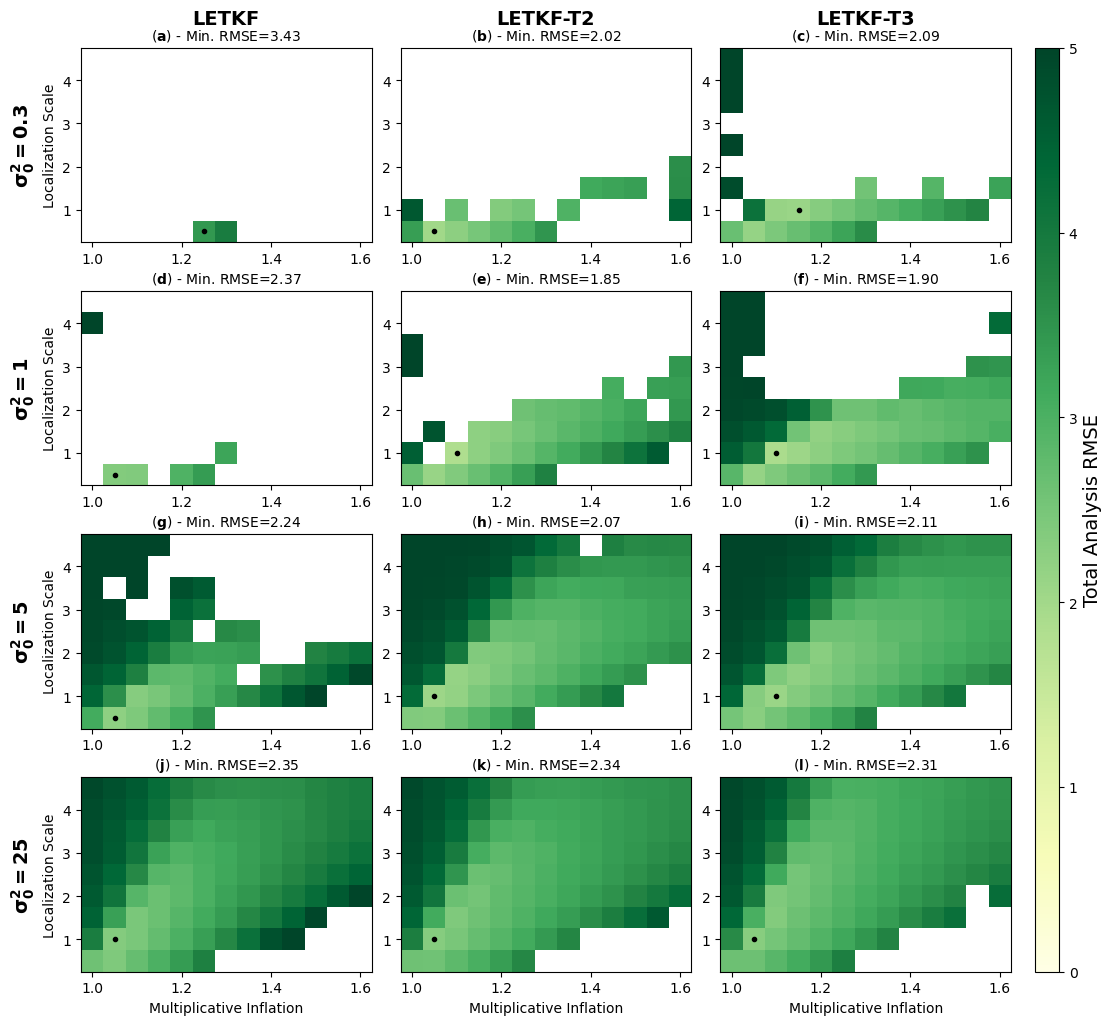

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
import common_function as cf
# Configuración
obs_errs = ['0.3', '1', '5', '25']
ntemps = [1, 2, 3]
labels = ['LETKF', 'LETKF-T2', 'LETKF-T3']
base_path  = '/home/jorge.gacitua/experimentos/L96_multiple_experiments/data/LETKF/'
output_dir = '/home/jorge.gacitua/experimentos/L96_multiple_experiments/figures'
nens = 20
freq = 4
den = 0.5
alpha = 2
gec = '_NOGEC'
fig, axes = plt.subplots(len(obs_errs), len(ntemps), figsize=(12, 12), 
                         sharex=False, sharey=False, 
                         gridspec_kw={'hspace': 0.25, 'wspace': 0.1})


cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77])  # x, y, width, height

vmin, vmax = 0, 5
panel_label_counter = 0

for i, obs in enumerate(obs_errs):
    for j, ntemp in enumerate(ntemps):
        #filename = f'ORIG_LETKF_Paper_Nature_Freq{freq}_Den{den}_Type3_ObsErr{obs}_Nens20_NTemp{ntemp}{gec}.npz'
        filename = f'LETKF_Paper_Nature_Freq{freq}_Den{den}_Type3_ObsErr{obs}_Nens{nens}_NTemp{ntemp}_alpha{alpha}{gec}.npz'
        filepath = os.path.join(base_path, filename)

        ax = axes[i, j]

        if os.path.exists(filepath):
            data = np.load(filepath, allow_pickle=True)
            #results = data['results']
            mult_inf_range = data['mult_inf_range']
            loc_scale_range = data['loc_scale_range']
            #print(data['AlphaTempList'])
            total_analysis_rmse = data['total_analysis_rmse']

            NormalEnd = 1 - data['NormalEnd']
            NormalEnd = NormalEnd.astype(bool)
            total_analysis_rmse[NormalEnd] = np.nan
            total_analysis_rmse = cf.outlier_rmse_filter( total_analysis_rmse )

            min_rmse = np.nanmin(total_analysis_rmse)
            idx_min = np.where(total_analysis_rmse == min_rmse)
            best_mult_inf = mult_inf_range[idx_min[0][0]]
            best_loc_scale = loc_scale_range[idx_min[1][0]]
 
            im = ax.pcolormesh(mult_inf_range, loc_scale_range, total_analysis_rmse.T, 
                               vmin=vmin, vmax=vmax, cmap='YlGn',edgecolors='lightgray',linewidth=0.001)
            ax.plot(best_mult_inf, best_loc_scale, 'k.', markersize=6)

            panel_label = rf"$\bf{{{chr(97 + panel_label_counter)}}}$"
            ax.set_title(f"({panel_label}) - Min. RMSE={min_rmse:.2f}", fontsize=10)
            panel_label_counter += 1

            if j == 0:
                ax.set_ylabel('Localization Scale', fontsize=10)
            if i == len(obs_errs) - 1:
                ax.set_xlabel('Multiplicative Inflation', fontsize=10)

for i, obs in enumerate(obs_errs):
    axes[i, 0].annotate(rf"$\bf{{\sigma^2_0 = {obs}}}$", xy=(-0.15, 0.5), xycoords='axes fraction',
                        rotation=90, va='center', ha='right', fontsize=14, weight='bold')
for j, t in enumerate(ntemps):
    axes[0, j].annotate(labels[j], xy=(0.5, 1.15), xycoords='axes fraction',
                        va='center', ha='center', fontsize=14, weight='bold')
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Total Analysis RMSE', fontsize=14)

os.makedirs(output_dir, exist_ok=True)
figname = f"Figure_AnalysisRMSE_Nens{nens}_Freq{freq}_Den{den}_Type3_ObsErr{obs}_NTemp{ntemp}{gec}"
output_pdf = os.path.join(output_dir, f"{figname}.pdf")
output_png = os.path.join(output_dir, f"{figname}.png")

plt.savefig(output_pdf, dpi=300, bbox_inches='tight', format='pdf')
plt.savefig(output_png, dpi=300, bbox_inches='tight', format='png')
#plt.show()

print(f"Figure saved as: \n PDF: {output_pdf} \n PNG: {output_png}")

### Sensibilidad al numero de Ensambles

/home/jorge.gacitua/experimentos/L96_multiple_experiments/data/LETKF/LETKF_Paper_Nature_Freq4_Den0.5_Type3_ObsErr5_Nens10_NTemp1_alpha2_NOGEC.npz
/home/jorge.gacitua/experimentos/L96_multiple_experiments/data/LETKF/LETKF_Paper_Nature_Freq4_Den0.5_Type3_ObsErr5_Nens10_NTemp2_alpha2_NOGEC.npz
/home/jorge.gacitua/experimentos/L96_multiple_experiments/data/LETKF/LETKF_Paper_Nature_Freq4_Den0.5_Type3_ObsErr5_Nens10_NTemp3_alpha2_NOGEC.npz
/home/jorge.gacitua/experimentos/L96_multiple_experiments/data/LETKF/LETKF_Paper_Nature_Freq4_Den0.5_Type3_ObsErr5_Nens20_NTemp1_alpha2_NOGEC.npz
/home/jorge.gacitua/experimentos/L96_multiple_experiments/data/LETKF/LETKF_Paper_Nature_Freq4_Den0.5_Type3_ObsErr5_Nens20_NTemp2_alpha2_NOGEC.npz
/home/jorge.gacitua/experimentos/L96_multiple_experiments/data/LETKF/LETKF_Paper_Nature_Freq4_Den0.5_Type3_ObsErr5_Nens20_NTemp3_alpha2_NOGEC.npz
/home/jorge.gacitua/experimentos/L96_multiple_experiments/data/LETKF/LETKF_Paper_Nature_Freq4_Den0.5_Type3_ObsErr5_Nens40_NT

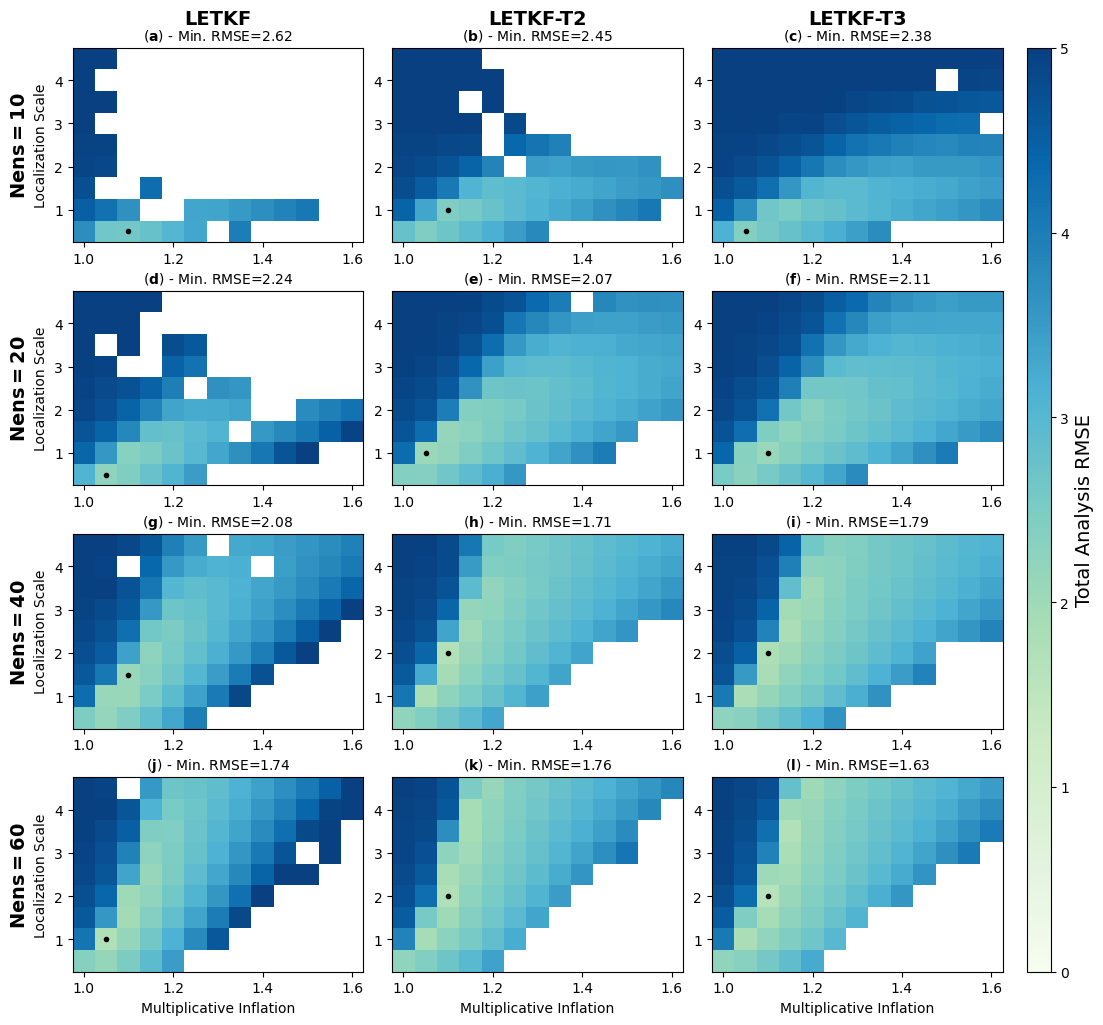

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import common_function as cf
# Configuración
ntemps = [1, 2, 3]
labels = ['LETKF', 'LETKF-T2', 'LETKF-T3']
nens = [10, 20, 40, 60]
base_path  = '/home/jorge.gacitua/experimentos/L96_multiple_experiments/data/LETKF/'
output_dir = '/home/jorge.gacitua/experimentos/L96_multiple_experiments/figures'
freq = 4
den = 0.5
alpha = 2
ObseErr = '5'
gec = 'NOGEC'
fig, axes = plt.subplots(len(nens), len(ntemps), figsize=(12, 12), 
                         sharex=False, sharey=False, 
                         gridspec_kw={'hspace': 0.25, 'wspace': 0.1})


cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77])  # x, y, width, height

vmin, vmax = 0, 5
panel_label_counter = 0

for i, nen in enumerate(nens):
    for j, ntemp in enumerate(ntemps):
    #filename = f'Tempered_LETKF_nens{str(nen).zfill(3)}_MultipleNature_Nature_Freq{freq}_Den{den}_Type3_ObsErr{ObseErr}.npz'
        filename = f'LETKF_Paper_Nature_Freq{freq}_Den{den}_Type3_ObsErr{ObseErr}_Nens{nen}_NTemp{ntemp}_alpha{alpha}_{gec}.npz'
        filepath = os.path.join(base_path, filename)
        print(filepath)
        

        if os.path.exists(filepath):
            data = np.load(filepath, allow_pickle=True)
            #results = data['results']
            mult_inf_range = data['mult_inf_range']
            loc_scale_range = data['loc_scale_range']

            ax = axes[i, j]
            total_analysis_rmse = data['total_analysis_rmse']
            NormalEnd = 1 - data['NormalEnd']
            NormalEnd = NormalEnd.astype(bool)
            total_analysis_rmse[NormalEnd] = np.nan
            total_analysis_rmse = cf.outlier_rmse_filter( total_analysis_rmse )
            min_rmse = np.nanmin(total_analysis_rmse)
            idx_min = np.where(total_analysis_rmse == min_rmse)
            best_mult_inf = mult_inf_range[idx_min[0][0]]
            best_loc_scale = loc_scale_range[idx_min[1][0]]

            im = ax.pcolormesh(mult_inf_range, loc_scale_range, total_analysis_rmse.T, 
                                vmin=vmin, vmax=vmax, cmap='GnBu',edgecolors='lightgray',linewidth=0.001)
            ax.plot(best_mult_inf, best_loc_scale, 'k.', markersize=6)

            panel_label = rf"$\bf{{{chr(97 + panel_label_counter)}}}$"
            ax.set_title(f"({panel_label}) - Min. RMSE={min_rmse:.2f}", fontsize=10)
            panel_label_counter += 1

            if j == 0:
                ax.set_ylabel('Localization Scale', fontsize=10)
            if i == len(nens) - 1:
                ax.set_xlabel('Multiplicative Inflation', fontsize=10)

for i, nen in enumerate(nens):
    axes[i, 0].annotate(rf"$\bf{{Nens = {nen}}}$", xy=(-0.15, 0.5), xycoords='axes fraction',
                        rotation=90, va='center', ha='right', fontsize=14, weight='bold')
for j, t in enumerate(ntemps):
    axes[0, j].annotate(labels[j], xy=(0.5, 1.15), xycoords='axes fraction',
                        va='center', ha='center', fontsize=14, weight='bold')
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Total Analysis RMSE', fontsize=14)

os.makedirs(output_dir, exist_ok=True)
figname = f"Figure_Nens_AnalysisRMSE_Freq{freq}_Den{den}_Type3"
output_pdf = os.path.join(output_dir, f"{figname}.pdf")
output_png = os.path.join(output_dir, f"{figname}.png")

plt.savefig(output_pdf, dpi=300, bbox_inches='tight', format='pdf')
plt.savefig(output_png, dpi=300, bbox_inches='tight', format='png')
#plt.show()

print(f"Figure saved as: \n PDF: {output_pdf} \n PNG: {output_png}")

/home/jorge.gacitua/experimentos/L96_multiple_experiments/data/LETKF/LETKF_Paper_Nature_Freq4_Den0.5_Type3_ObsErr5_Nens20_NTemp1_alpha0_NOGEC.npz
/home/jorge.gacitua/experimentos/L96_multiple_experiments/data/LETKF/LETKF_Paper_Nature_Freq4_Den0.5_Type3_ObsErr5_Nens20_NTemp2_alpha0_NOGEC.npz
/home/jorge.gacitua/experimentos/L96_multiple_experiments/data/LETKF/LETKF_Paper_Nature_Freq4_Den0.5_Type3_ObsErr5_Nens20_NTemp3_alpha0_NOGEC.npz
/home/jorge.gacitua/experimentos/L96_multiple_experiments/data/LETKF/LETKF_Paper_Nature_Freq4_Den0.5_Type3_ObsErr5_Nens20_NTemp1_alpha1_NOGEC.npz
/home/jorge.gacitua/experimentos/L96_multiple_experiments/data/LETKF/LETKF_Paper_Nature_Freq4_Den0.5_Type3_ObsErr5_Nens20_NTemp2_alpha1_NOGEC.npz
/home/jorge.gacitua/experimentos/L96_multiple_experiments/data/LETKF/LETKF_Paper_Nature_Freq4_Den0.5_Type3_ObsErr5_Nens20_NTemp3_alpha1_NOGEC.npz
/home/jorge.gacitua/experimentos/L96_multiple_experiments/data/LETKF/LETKF_Paper_Nature_Freq4_Den0.5_Type3_ObsErr5_Nens20_NT

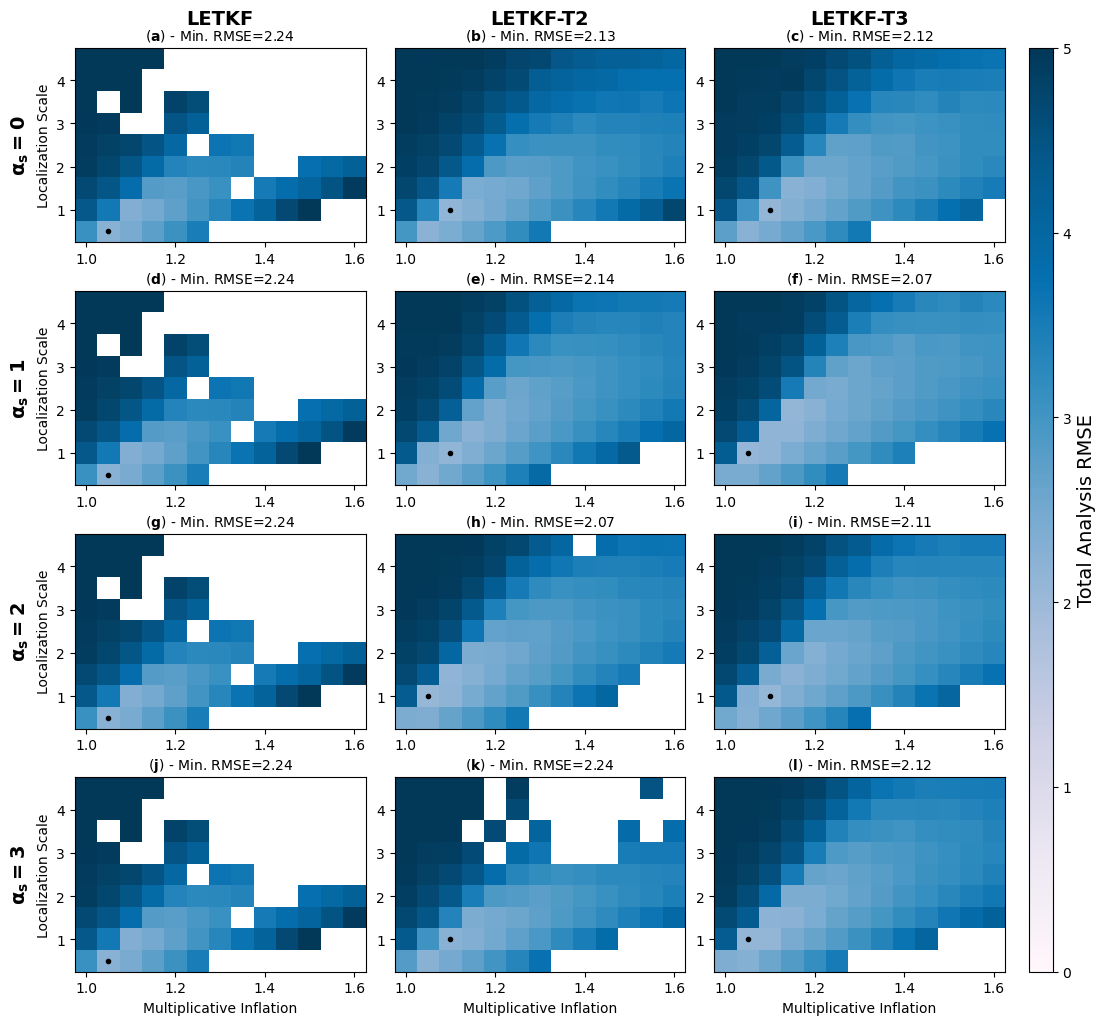

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import common_function as cf
# Configuración

base_path  = '/home/jorge.gacitua/experimentos/L96_multiple_experiments/data/LETKF/'
output_dir = '/home/jorge.gacitua/experimentos/L96_multiple_experiments/figures'
ntemps = [1, 2, 3]
labels = ['LETKF', 'LETKF-T2', 'LETKF-T3']
freq = 4
den = 0.5
alphas = [0,1,2,3]
nen = 20
ObseErr = '5'
gec = '_NOGEC'
fig, axes = plt.subplots(len(alphas), len(ntemps), figsize=(12, 12), 
                         sharex=False, sharey=False, 
                         gridspec_kw={'hspace': 0.25, 'wspace': 0.1})

cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77])  # x, y, width, height
vmin, vmax = 0, 5
panel_label_counter = 0

for i, alpha in enumerate(alphas):
    for j, ntemp in enumerate(ntemps):
        # Load the data
        filename = f'LETKF_Paper_Nature_Freq{freq}_Den{den}_Type3_ObsErr{ObseErr}_Nens{nen}_NTemp{ntemp}_alpha{alpha}{gec}.npz'
        filepath = os.path.join(base_path, filename)
        print(filepath)
        # Check if the file exists
        if os.path.exists(filepath):
            ax = axes[i, j]
            data = np.load(filepath, allow_pickle=True)
            mult_inf_range = data['mult_inf_range']
            loc_scale_range = data['loc_scale_range']
            total_analysis_rmse = data['total_analysis_rmse']

            NormalEnd = 1 - data['NormalEnd']
            NormalEnd = NormalEnd.astype(bool)
            total_analysis_rmse[NormalEnd] = np.nan
            total_analysis_rmse = cf.outlier_rmse_filter( total_analysis_rmse )

            min_rmse = np.nanmin(total_analysis_rmse)
            idx_min = np.where(total_analysis_rmse == min_rmse)
            best_mult_inf = mult_inf_range[idx_min[0][0]]
            best_loc_scale = loc_scale_range[idx_min[1][0]]

            im = ax.pcolormesh(mult_inf_range, loc_scale_range, total_analysis_rmse.T, 
                                vmin=vmin, vmax=vmax, cmap='PuBu',edgecolors='lightgray',linewidth=0.001)
            ax.plot(best_mult_inf, best_loc_scale, 'k.', markersize=6)

            panel_label = rf"$\bf{{{chr(97 + panel_label_counter)}}}$"
            ax.set_title(f"({panel_label}) - Min. RMSE={min_rmse:.2f}", fontsize=10)
            panel_label_counter += 1

            if j == 0:
                ax.set_ylabel('Localization Scale', fontsize=10)
            if i == len(alphas) - 1:
                ax.set_xlabel('Multiplicative Inflation', fontsize=10)

for i, alpha in enumerate(alphas):
    axes[i, 0].annotate(rf"$\bf{{\alpha_s = {alpha}}}$", xy=(-0.15, 0.5), xycoords='axes fraction',
                        rotation=90, va='center', ha='right', fontsize=14, weight='bold')
for j, t in enumerate(ntemps):
    axes[0, j].annotate(labels[j], xy=(0.5, 1.15), xycoords='axes fraction',
                        va='center', ha='center', fontsize=14, weight='bold')
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Total Analysis RMSE', fontsize=14)

os.makedirs(output_dir, exist_ok=True)
figname = f"Figure_Alpha_AnalysisRMSE_Freq{freq}_Den{den}_Type3"
output_pdf = os.path.join(output_dir, f"{figname}.pdf")
output_png = os.path.join(output_dir, f"{figname}.png")

plt.savefig(output_pdf, dpi=300, bbox_inches='tight', format='pdf')
plt.savefig(output_png, dpi=300, bbox_inches='tight', format='png')
#plt.show()

print(f"Figure saved as: \n PDF: {output_pdf} \n PNG: {output_png}")

In [22]:
import matplotlib.pyplot as plt
import numpy as np
#plt.rc('font', size=14)          # controls default text sizes
#plt.rc('axes', titlesize=16)     # fontsize of the axes title
#plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
#plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
#plt.rc('legend', fontsize=14)    # legend fontsize
#plt.rc('figure', titlesize=18)   # fontsize of the figure title
# Load RMSE values
base_path  = '/home/jorge.gacitua/experimentos/L96_multiple_experiments/data/LETKF/'
output_dir = '/home/jorge.gacitua/experimentos/L96_multiple_experiments/figures'

freq_numbers   = [4]
obserr_numbers = [5]#[0.3,1,5,25]
Den_values     = [0.5,1] 
alpha_range    = np.array([0,1,2,3])
nens_labels    = [10, 20, 40, 60, 100]
niter_labels   = [1, 2, 3]    # Labels for columns

for Freq in freq_numbers:
    for ObseErr in obserr_numbers:
        for Den in Den_values:
            rmse_values = np.zeros((len(nens_labels), len(alpha_range), len(niter_labels)))
            for ialpha,alpha in enumerate(alpha_range):
                for iens, Nens in enumerate(nens_labels):
                    for k,ntemp in enumerate(niter_labels):
                        ntemp = niter_labels[k]

                        filename = f'LETKF_Paper_Nature_Freq{Freq}_Den{Den}_Type3_ObsErr{ObseErr}_Nens{Nens}_NTemp{ntemp}_alpha{alpha}_NOGEC.npz'
                        filepath = os.path.join(base_path, filename)
                        #print(filepath)
                        # Check if the file exists
                        if os.path.exists(filepath):
                            data = np.load(filepath, allow_pickle=True)
                            mult_inf_range = data['mult_inf_range']
                            loc_scale_range = data['loc_scale_range']
                            total_analysis_rmse = data['total_analysis_rmse']

                            NormalEnd = 1 - data['NormalEnd']
                            NormalEnd = NormalEnd.astype(bool)
                            total_analysis_rmse[NormalEnd] = np.nan
                            total_analysis_rmse = cf.outlier_rmse_filter( total_analysis_rmse )

                            min_rmse = np.nanmin(total_analysis_rmse)
                            print(min_rmse)                  
                            rmse_values[iens, ialpha, k] = min_rmse
                        else:
                            print(f"File not found: {filepath}")
            #print(rmse_values)
            filename = f'rmse_values_frec{Freq}_den{Den}_obs{ObseErr}.npz'
            file_out_path = os.path.join(base_path, filename)
            #np.savez_compressed(file_out_path, rmse_values=rmse_values)



File not found: /home/jorge.gacitua/experimentos/L96_multiple_experiments/data/LETKF/LETKF_Paper_Nature_Freq4_Den0.5_Type3_ObsErr5_Nens10_NTemp1_alpha0_NOGEC.npz
File not found: /home/jorge.gacitua/experimentos/L96_multiple_experiments/data/LETKF/LETKF_Paper_Nature_Freq4_Den0.5_Type3_ObsErr5_Nens10_NTemp2_alpha0_NOGEC.npz
File not found: /home/jorge.gacitua/experimentos/L96_multiple_experiments/data/LETKF/LETKF_Paper_Nature_Freq4_Den0.5_Type3_ObsErr5_Nens10_NTemp3_alpha0_NOGEC.npz
2.241240800376482
2.133622125987285
2.121843773887727
File not found: /home/jorge.gacitua/experimentos/L96_multiple_experiments/data/LETKF/LETKF_Paper_Nature_Freq4_Den0.5_Type3_ObsErr5_Nens40_NTemp1_alpha0_NOGEC.npz
File not found: /home/jorge.gacitua/experimentos/L96_multiple_experiments/data/LETKF/LETKF_Paper_Nature_Freq4_Den0.5_Type3_ObsErr5_Nens40_NTemp2_alpha0_NOGEC.npz
File not found: /home/jorge.gacitua/experimentos/L96_multiple_experiments/data/LETKF/LETKF_Paper_Nature_Freq4_Den0.5_Type3_ObsErr5_Nens4

/tmp/ipykernel_1133446/2802683344.py:29: RuntimeWarning: invalid value encountered in divide
  percent_diff_2_1 = ((rmse_values[:,:,1] - rmse_values[:,:,0]) / rmse_values[:,:,0]) * 100
/tmp/ipykernel_1133446/2802683344.py:30: RuntimeWarning: invalid value encountered in divide
  percent_diff_3_1 = ((rmse_values[:,:,2] - rmse_values[:,:,0]) / rmse_values[:,:,0]) * 100


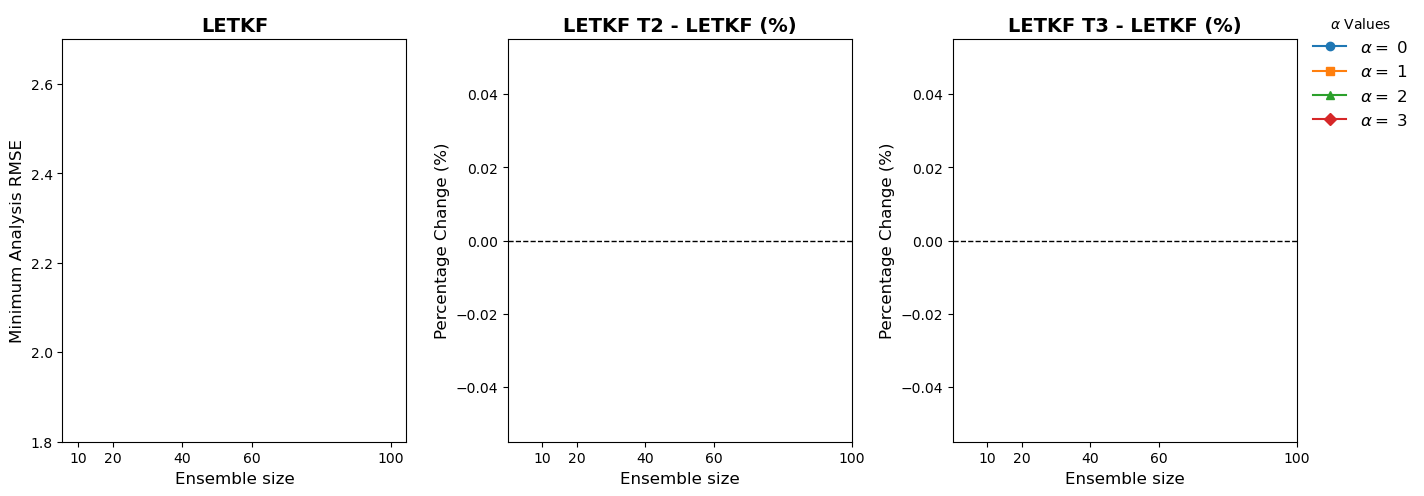

In [10]:

####################################################################################################
######################################### PLOT RMSE VALUES #########################################
####################################################################################################
Freq = 4
Den = 0.5
ObseErr = 5
filename = f'rmse_values_frec{Freq}_den{Den}_obs{ObseErr}.npz'
file_out_path = os.path.join(base_path, filename)
rmse_data = np.load(file_out_path)
rmse_values = rmse_data['rmse_values']

# Define parameters
nens_labels = np.array([10, 20, 40, 60, 100])
alpha_range = np.array([0, 1, 2, 3])
x = np.arange(len(nens_labels))  # X positions for categories

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',]  # Colors for alphas
markers = ['o', 's', '^', 'D']  # Different markers for alphas

fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=False)  # Adjust width and height for better layout

# First subplot: Only plot values for alpha=1
alpha_idx = 0  # Select alpha=1
axes[0].plot(nens_labels, rmse_values[:, alpha_idx,0], marker=markers[alpha_idx], linestyle='-', 
             color=colors[alpha_idx], label=f'Alpha {alpha_idx}')
axes[0].set_title('LETKF', fontsize=14, fontweight='bold')
axes[0].set_ylim(1.8, 2.7)  # Adjust y-axis limits
# Calculate percentage differences
percent_diff_2_1 = ((rmse_values[:,:,1] - rmse_values[:,:,0]) / rmse_values[:,:,0]) * 100
percent_diff_3_1 = ((rmse_values[:,:,2] - rmse_values[:,:,0]) / rmse_values[:,:,0]) * 100

# Second subplot: Percentage change Iteration 2 - Iteration 1
for i, alpha in enumerate(alpha_range):
    axes[1].plot(nens_labels, percent_diff_2_1[:, i], marker=markers[i], linestyle='-', 
                 color=colors[i], label=fr'$\alpha =$ {alpha}')
axes[1].set_title('LETKF T2 - LETKF (%)', fontsize=14, fontweight='bold')

# Third subplot: Percentage change Iteration 3 - Iteration 1
for i, alpha in enumerate(alpha_range):
    axes[2].plot(nens_labels, percent_diff_3_1[:, i], marker=markers[i], linestyle='-', 
                 color=colors[i], label=f'Alpha {alpha}')
axes[2].set_title('LETKF T3 - LETKF (%)', fontsize=14, fontweight='bold')

# Axis labels and formatting
for ax in axes:
    ax.set_xticks(nens_labels)
    ax.set_xlabel("Ensemble size", fontsize=12)
    ax.axhline(0, color='black', linestyle='--', linewidth=1)  # Add horizontal line at 0 for percentage differences

axes[0].set_ylabel("Minimum Analysis RMSE", fontsize=12)
axes[1].set_ylabel("Percentage Change (%)", fontsize=12)
axes[2].set_ylabel("Percentage Change (%)", fontsize=12)

# Move single legend outside the plot
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, title=r"$\alpha$ Values", loc='upper right', bbox_to_anchor=(1.02, 1), frameon=False, fontsize=12)

#fig.suptitle("RMSE vs Number of Ensembles (Grouped by Iterations)", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 0.95, 1])  # Adjust layout to fit legend properly
plt.show()
